In [1]:
from bnn_priors.exp_utils import get_model
import torch
%pdb
model = get_model(torch.zeros((1, 3 * 32**2)), torch.zeros((1,), dtype=torch.int64)+9,
              "datadriven_resnet18", 64, 3, "fixedcov_gennorm", 0,
             1., "gaussian", 0, 1., True,
             {"beta": 2.0, "mean_covs_file": "../bnn_priors/models/cifar10_mean_covs.pkl.gz",
             "fits_dict_file": "../bnn_priors/models/cifar10_weight_fits.pkl.gz"}, {})


Automatic pdb calling has been turned ON


In [2]:
%pdb off
model

Automatic pdb calling has been turned OFF


ClassificationModel(
  (net): DummyModule(
    (module): PreActResNet(
      (conv1): Conv2d(
        3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (weight_prior): FixedCovGenNorm()
      )
      (layer1): Sequential(
        (0): PreActBlock(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(
            64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
            (weight_prior): FixedCovGenNorm()
          )
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(
            64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
            (weight_prior): FixedCovGenNorm()
          )
        )
        (1): PreActBlock(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(
            64, 64, kernel_size=(3, 3

In [2]:
for k, v in model.state_dict().items():
    if v.numel() < 3:
        print(k, v)
    else:
        print(k)

net.module.conv1.weight_prior.p
net.module.conv1.weight_prior.loc
net.module.conv1.weight_prior.scale
net.module.conv1.weight_prior.inv_scale
net.module.conv1.weight_prior.log_sqrt_vals tensor([[-36.2131]])
net.module.conv1.weight_prior.beta tensor(0.3714)
net.module.conv1.weight_prior.base_scale tensor(0.0207)
net.module.layer1.0.bn1.weight
net.module.layer1.0.bn1.bias
net.module.layer1.0.bn1.running_mean
net.module.layer1.0.bn1.running_var
net.module.layer1.0.bn1.num_batches_tracked tensor(0)
net.module.layer1.0.conv1.weight_prior.p
net.module.layer1.0.conv1.weight_prior.loc
net.module.layer1.0.conv1.weight_prior.scale
net.module.layer1.0.conv1.weight_prior.inv_scale
net.module.layer1.0.conv1.weight_prior.log_sqrt_vals tensor([[-48.1027]])
net.module.layer1.0.conv1.weight_prior.beta tensor(0.2531)
net.module.layer1.0.conv1.weight_prior.base_scale tensor(0.0007)
net.module.layer1.0.bn2.weight
net.module.layer1.0.bn2.bias
net.module.layer1.0.bn2.running_mean
net.module.layer1.0.bn2.run

In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import seaborn as sns
import json
import torch
import gpytorch
import h5py
import collections
import scipy
import torch

from bnn_priors import prior

from bnn_priors.exp_utils import load_samples

%matplotlib inline

In [4]:
sd = []
for i in range(1):
    model.sample_all_priors()
    sd.append(model.state_dict())
    
samples = {}
for k in [k for k in sd[0].keys() if k.endswith(".p")]:
    l = []
    for s in sd:
        l.append(s[k])
    samples[k] = torch.stack(l).numpy()

# Explore weights of the MNIST network, that doesn't have batchnorm

In [5]:
samples.keys()

dict_keys(['net.module.conv1.weight_prior.p', 'net.module.layer1.0.conv1.weight_prior.p', 'net.module.layer1.0.conv2.weight_prior.p', 'net.module.layer1.1.conv1.weight_prior.p', 'net.module.layer1.1.conv2.weight_prior.p', 'net.module.layer2.0.conv1.weight_prior.p', 'net.module.layer2.0.conv2.weight_prior.p', 'net.module.layer2.0.shortcut.0.weight_prior.p', 'net.module.layer2.1.conv1.weight_prior.p', 'net.module.layer2.1.conv2.weight_prior.p', 'net.module.layer3.0.conv1.weight_prior.p', 'net.module.layer3.0.conv2.weight_prior.p', 'net.module.layer3.0.shortcut.0.weight_prior.p', 'net.module.layer3.1.conv1.weight_prior.p', 'net.module.layer3.1.conv2.weight_prior.p', 'net.module.layer4.0.conv1.weight_prior.p', 'net.module.layer4.0.conv2.weight_prior.p', 'net.module.layer4.0.shortcut.0.weight_prior.p', 'net.module.layer4.1.conv1.weight_prior.p', 'net.module.layer4.1.conv2.weight_prior.p', 'net.module.linear.weight_prior.p', 'net.module.linear.bias_prior.p'])

In [6]:
samples_reshaped = {}
mean_covs = {}

for k in samples.keys():
    if "weight_prior" in k and k != 'net.module.linear.weight_prior.p' and "shortcut" not in k:
        #if k == "net.module.8.weight_prior.p":
        #    samples_reshaped[k] = samples[k].transpose((0, 2, 1)).reshape((-1, 10))
        #else:
        samples_reshaped[k] = samples[k].reshape((-1, samples[k].shape[-2]*samples[k].shape[-1]))
        mean_covs[k] = (np.mean(samples_reshaped[k], 0), np.cov(samples_reshaped[k], rowvar=False))
    else:
        samples_reshaped[k] = samples[k]    
        mean_covs[k] = (np.mean(samples[k]), np.var(samples[k]))

In [7]:
[k for k in samples.keys() if "shortcut" in k]

['net.module.layer2.0.shortcut.0.weight_prior.p',
 'net.module.layer3.0.shortcut.0.weight_prior.p',
 'net.module.layer4.0.shortcut.0.weight_prior.p']

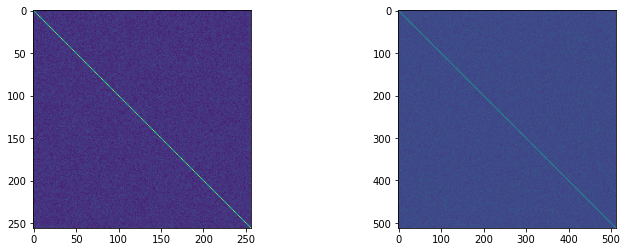

In [11]:
a = samples['net.module.layer4.0.shortcut.0.weight_prior.p']

_, axes = plt.subplots(1, 2, figsize=(12, 4))
cov = np.cov(a.reshape((1*512, 256)), rowvar=False)
axes[0].imshow((np.diag(cov)[:, None]*np.diag(cov))**-.5 * cov)
cov = np.cov(a.transpose((1, 0, 2, 3, 4)).reshape((512, 1*256)), rowvar=True)
axes[1].imshow((np.diag(cov)[:, None]*np.diag(cov))**-.5 * cov)

In [12]:
samples['net.module.linear.weight_prior.p'].shape

(1, 10, 512)

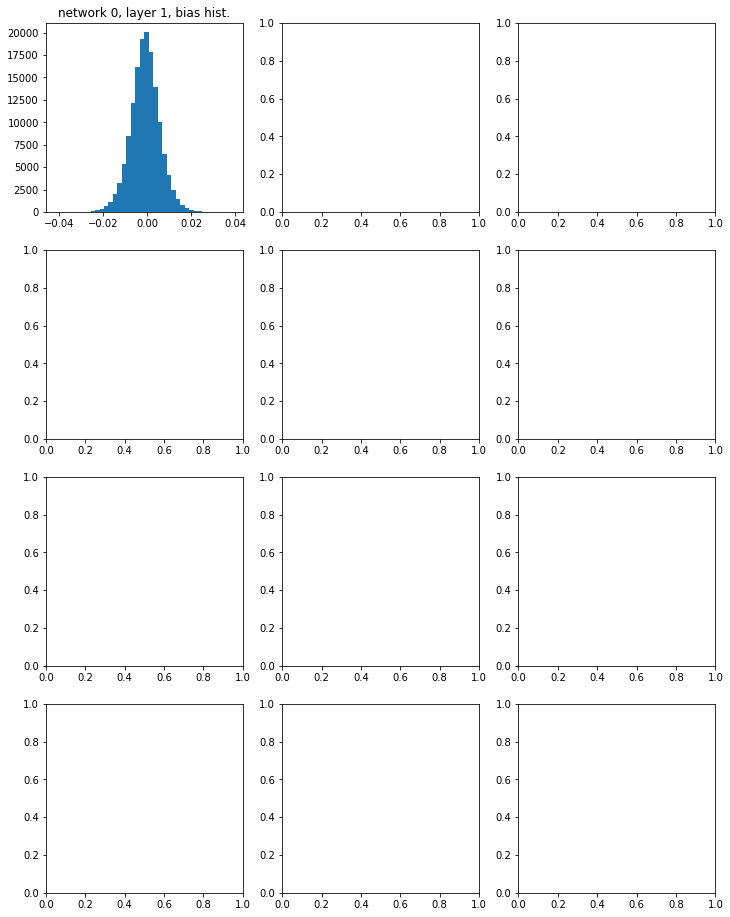

In [14]:
_, axes = plt.subplots(4, 3, figsize=(12, 16))
for i, s in enumerate(samples['net.module.layer2.0.conv2.weight_prior.p'].reshape((1, -1))):
    axes.flat[i].hist(s, bins=40)
    axes.flat[i].set_title(f"network {i}, layer 1, bias hist.")

Text(0.5, 1.0, 'Final layer bias hist.')

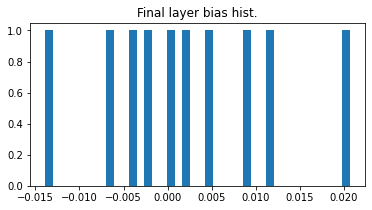

In [15]:
_, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(samples['net.module.linear.bias_prior.p'].flat, bins=40)
ax.set_title("Final layer bias hist.")

IndexError: index 1 is out of bounds for axis 0 with size 1

> <ipython-input-16-2f49bb530cdd>(3)<module>()
      1 _, ax = plt.subplots(1, 1, figsize=(6, 3))
      2 for i in range(7):
----> 3     ax.plot(samples['net.module.linear.bias_prior.p'][i])
      4 ax.set_title("Final layer bias hist.")

ipdb> 


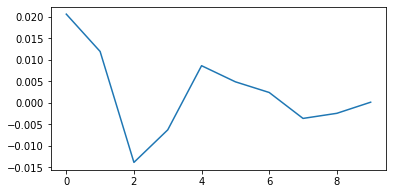

In [16]:
_, ax = plt.subplots(1, 1, figsize=(6, 3))
for i in range(7):
    ax.plot(samples['net.module.linear.bias_prior.p'][i])
ax.set_title("Final layer bias hist.")

In [ ]:
sum(len(var.shape) == 2 for k, (_, var) in mean_covs.items())

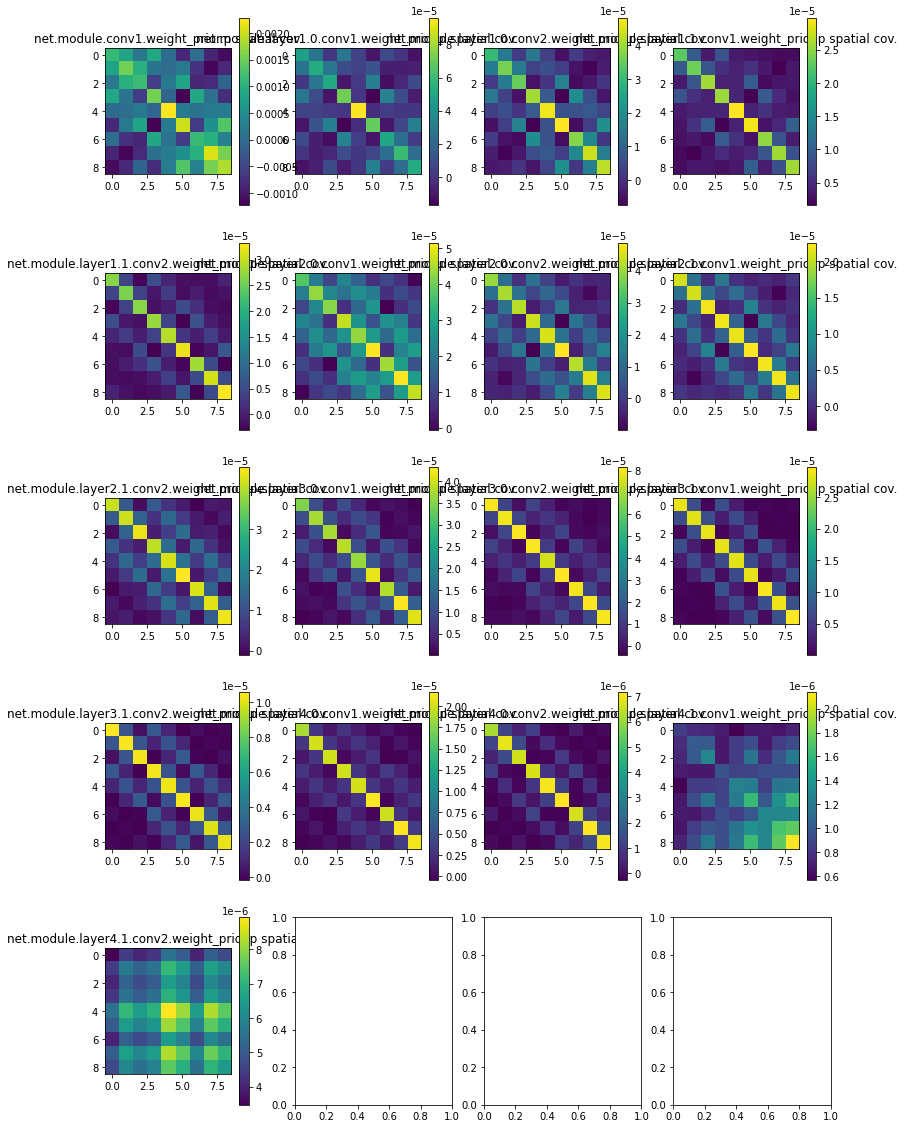

In [17]:
fig, axes = plt.subplots(5, 4, figsize=(13, 20))

i = 0
for key, (_, cov) in mean_covs.items():
    if len(cov.shape) != 2:
        continue
    ax = axes.flat[i]
    i += 1
    
    mappable = ax.imshow(mean_covs[key][1], cmap=plt.get_cmap('viridis'))
    fig.colorbar(mappable, ax=ax)
    ax.set_title(f"{key} spatial cov.")


Text(0.5, 1.0, 'final linear')

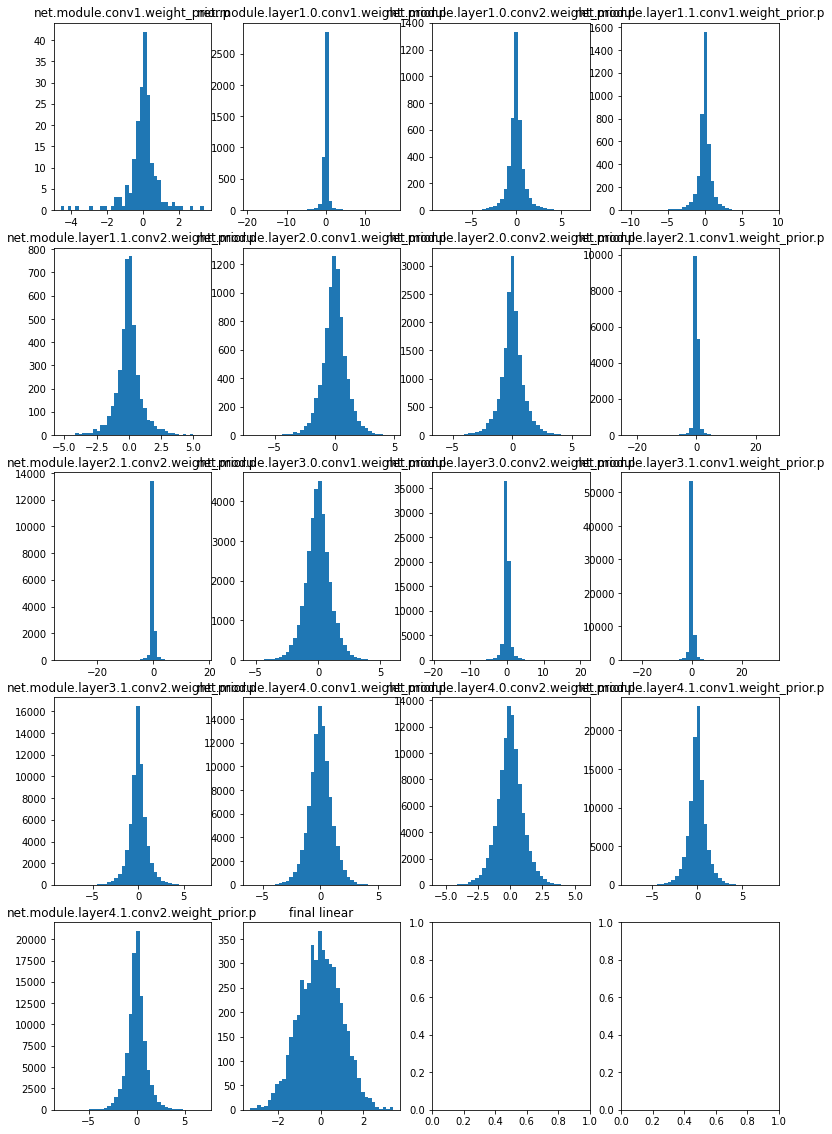

In [18]:
fig, axes = plt.subplots(5, 4, figsize=(13, 20))

whites = {}

i = 0
for key, (_, cov) in mean_covs.items():
    if len(cov.shape) != 2:
        continue
    ax = axes.flat[i]
    i += 1
    
    a = samples_reshaped[key] - mean_covs[key][0]
    vals, vecs = np.linalg.eig(mean_covs[key][1])
    whites[key] = a_white = a @ (vecs * vals**-.5)
    perm = np.random.permutation(len(a_white))
    heights, bins, _ = ax.hist(a_white.ravel()[perm[:100000]], bins=40)
    area = (bins[1:] - bins[:-1]) @ heights
    
    
    ax.set_title(key)
    
axes.flat[i].hist(samples_reshaped['net.module.linear.weight_prior.p'].ravel(), bins=40)
axes.flat[i].set_title("final linear")

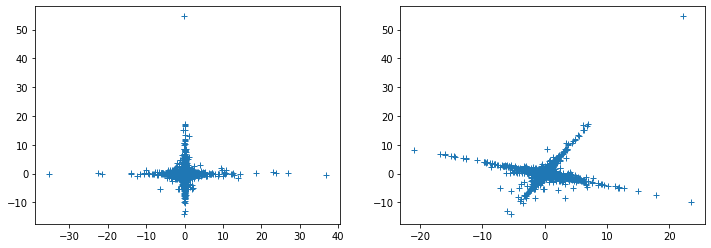

In [28]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))

key = 'net.module.layer2.1.conv2.weight_prior.p'
axes[0].plot(whites[key][:len(whites[key]), 0],
             whites[key][:len(whites[key]), 8], ls='none', marker='+')
axes[1].plot(whites[key][:len(whites[key]), 7],
             whites[key][:len(whites[key]), 8], ls='none', marker='+')